In [4]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import yahoo_fin.stock_info as si
import yfinance as yf

In [238]:
# import requests
# requests.get('https://invest-journal.ru/top-50-kompanij-iz-indeksa-sp-500-po-sostojaniju-na-2021-god').text
# s = """<td>Apple Inc.</td> <td>AAPL</td> </tr> <tr> <td>Microsoft Corp.</td> <td>MSFT</td> </tr> <tr> <td>Amazon.com Inc.</td> <td>AMZN</td> </tr> <tr> <td>Facebook Inc. Class A</td> <td>FB</td> </tr> <tr> <td>Alphabet Inc. Class A</td> <td>GOOGL</td> </tr> <tr> <td>Alphabet Inc. Class C</td> <td>GOOG</td> </tr> <tr> <td>Berkshire Hathaway Inc. Class B</td> <td>BRK.B</td> </tr> <tr> <td>Tesla</td> <td>TSLA</td> </tr> <tr> <td>NVIDIA Corp.</td> <td>NVDA</td> </tr> <tr> <td>JPMorgan Chase &#038; Co.</td> <td>JPM</td> </tr> <tr> <td>Johnson &#038; Johnson</td> <td>JNJ</td> </tr> <tr> <td>Visa Inc. Class A</td> <td>V</td> </tr> <tr> <td>UnitedHealth Group Inc.</td> <td>UNH</td> </tr> <tr> <td>PayPal Holdings Inc.</td> <td>PYPL</td> </tr> <tr> <td>Home Depot Inc.</td> <td>HD</td> </tr> <tr> <td>Procter &#038; Gamble Co.</td> <td>PG</td> </tr> <tr> <td>MasterCard Inc. Class A</td> <td>MA</td> </tr> <tr> <td>Walt Disney Company</td> <td>DIS</td> </tr> <tr> <td>Bank of America Corp.</td> <td>BAC</td> </tr> <tr> <td>Adobe Inc.</td> <td>ADBE</td> </tr> <tr> <td>Exxon Mobil Corp.</td> <td>XOM</td> </tr> <tr> <td>Comcast Corp. Class A</td> <td>CMCSA</td> </tr> <tr> <td>Netflix Inc.</td> <td>NFLX</td> </tr> <tr> <td>Verizon Communications Inc.</td> <td>VZ</td> </tr> <tr> <td>Intel Corp.</td> <td>INTC</td> </tr> <tr> <td>salesforce.com Inc.</td> <td>CRM</td> </tr> <tr> <td>Cisco Systems Inc.</td> <td>CSCO</td> </tr> <tr> <td>Pfizer Inc.</td> <td>PFE</td> </tr> <tr> <td>Coca-Cola Company</td> <td>KO</td> </tr> <tr> <td>Abbott Laboratories</td> <td>ABT</td> </tr> <tr> <td>AT&#038;T Inc.</td> <td>T</td> </tr> <tr> <td>PepsiCo Inc.</td> <td>PEP</td> </tr> <tr> <td>Chevron Corp.</td> <td>CVX</td> </tr> <tr> <td>AbbVie Inc.</td> <td>ABBV</td> </tr> <tr> <td>Thermo Fisher Scientific Inc.</td> <td>TMO</td> </tr> <tr> <td>NIKE Inc. Class B</td> <td>NKE</td> </tr> <tr> <td>Merck &#038; Co. Inc.</td> <td>MRK</td> </tr> <tr> <td>Broadcom Inc.</td> <td>AVGO</td> </tr> <tr> <td>Walmart Inc.</td> <td>WMT</td> </tr> <tr> <td>Accenture Plc Class A</td> <td>ACN</td> </tr> <tr> <td>Wells Fargo &#038; Company</td> <td>WFC</td> </tr> <tr> <td>Eli Lilly and Company</td> <td>LLY</td> </tr> <tr> <td>Texas Instruments Inc.</td> <td>TXN</td> </tr> <tr> <td>Costco Wholesale Corp.</td> <td>COST</td> </tr> <tr> <td>McDonald&#8217;s Corp.</td> <td>MCD</td> </tr> <tr> <td>Danaher Corp.</td> <td>DHR</td> </tr> <tr> <td>Medtronic Plc</td> <td>MDT</td> </tr> <tr> <td>Qualcomm Inc.</td> <td>QCOM</td> </tr> <tr> <td>Philip Morris Int&#8217;l Inc.</td> <td>PM</td> </tr> <tr> <td>Honeywell International Inc.</td> <td>HON</td>"""
# popular = [string.split('</td>')[0] for string in s.split('<td>')[1:][1::2]]

In [9]:
import sys
sys.path.append('../utils/')
from snp500_parser import parse_all_tickers

In [10]:
snp500_stock_names = si.tickers_sp500()
parse_all_tickers(snp500_stock_names, limit=10)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
spn500 = pd.read_csv('snp_500.csv')

In [9]:
snp500.dropna(axis=1, how='all', inplace=True)
snp500 = snp500.iloc[:, :-1]
snp500.head()

,shortName,sector,industry,country,market,2021-11-01 00:00:00,2021-11-02 00:00:00,2021-11-03 00:00:00,2021-11-04 00:00:00,2021-11-05 00:00:00,...,2022-04-14 00:00:00,2022-04-18 00:00:00,2022-04-19 00:00:00,2022-04-20 00:00:00,2022-04-21 00:00:00,2022-04-22 00:00:00,2022-04-25 00:00:00,2022-04-26 00:00:00,2022-04-27 00:00:00,2022-04-28 00:00:00
0,Apple Inc.,Technology,Consumer Electronics,United States,us_market,148.553650,149.610764,151.076767,150.548203,151.087509,...,165.289993,165.070007,167.399994,167.229996,166.419998,161.789993,162.880005,156.800003,156.570007,163.639999
1,Microsoft Corporation,Technology,Software—Infrastructure,United States,us_market,328.090118,331.835510,332.702148,335.132660,334.754120,...,279.829987,280.519989,285.299988,286.359985,280.809998,274.029999,280.720001,270.220001,283.220001,289.630005
2,"Amazon.com, Inc.",Consumer Cyclical,Internet Retail,United States,us_market,3318.110107,3312.750000,3384.000000,3477.000000,3518.989990,...,3034.129883,3055.699951,3162.310059,3079.959961,2965.919922,2887.000000,2921.479980,2787.820068,2763.340088,2891.929932
3,"Meta Platforms, Inc.",Communication Services,Internet Content & Information,United States,us_market,329.980011,328.079987,331.619995,335.850006,341.130005,...,210.179993,210.770004,217.309998,200.419998,188.070007,184.110001,186.990005,180.949997,174.949997,205.729996
4,Alphabet Inc.,Communication Services,Internet Content & Information,United States,us_market,2869.939941,2908.649902,2931.959961,2965.350098,2977.040039,...,2534.600098,2553.530029,2600.179932,2560.800049,2496.290039,2392.709961,2461.479980,2373.000000,2285.889893,2370.449951


In [89]:
visa = snp500.iloc[11].values[5:]
mastercard = snp500.iloc[16].values[5:]
apple = snp500.iloc[1].values[5:]

In [90]:
visa = (visa - np.mean(visa)) / np.std(visa)
mastercard = (mastercard - np.mean(mastercard)) / np.std(mastercard)
apple = (apple - np.mean(apple)) / np.std(apple)

In [91]:
import statsmodels.api as sm

In [125]:
str(round(np.linspace(0.1, 0.9, 9)[1], 1)).replace('.', '')

'02'

In [126]:
def calculate_features(ts):
    features = {
        # 'mean': np.mean(ts),
        'min': np.min(ts),
        'max': np.max(ts)
    }
    for i, autocorrelation in enumerate(sm.tsa.acf(ts, nlags=4)):
        if not i:
            continue
        features[f"acf_{i}"] = autocorrelation
    for q in np.linspace(0.1, 0.9, 9):
        features[f"q_{str(round(q, 1)).replace('.', '')}"] = np.quantile(ts, q)
    return features

In [127]:
to_df = [calculate_features(ts) for ts in [visa, mastercard, apple]]

In [128]:
%config InlineBackend.figure_formats = ['svg']

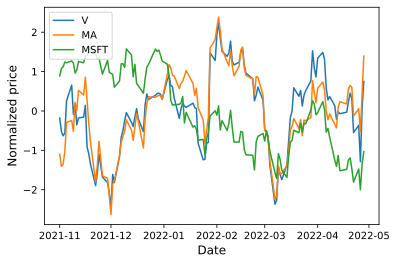

In [129]:
plt.plot(snp500.columns[5:].tolist(), visa, label='V')
plt.plot(snp500.columns[5:].tolist(), mastercard, label='MA')
plt.plot(snp500.columns[5:].tolist(), apple, label='MSFT')
plt.legend(loc='upper left')
plt.xlabel('Date', size=12)
plt.ylabel('Normalized price', size=12)
plt.show()

In [130]:
df = pd.DataFrame(to_df).round(2).T
columns = ['V', 'MA', 'MSFT']
df.columns = columns
df.T

,min,max,acf_1,acf_2,acf_3,acf_4,q_01,q_02,q_03,q_04,q_05,q_06,q_07,q_08,q_09
V,-2.46,2.25,0.89,0.78,0.67,0.56,-1.41,-0.80,-0.40,-0.14,0.11,0.28,0.44,0.77,1.33
MA,-2.63,2.38,0.89,0.77,0.66,0.55,-1.40,-0.78,-0.48,-0.23,0.04,0.37,0.57,0.86,1.15
MSFT,-2.00,1.60,0.95,0.91,0.86,0.81,-1.32,-0.99,-0.65,-0.46,-0.10,0.20,0.89,1.18,1.32


In [105]:
t[t == 0].index

Int64Index([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
           dtype='int64')

# Pytorch

In [147]:
import torch
import torch.nn as nn

In [148]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [149]:
snp500 = snp500[~(snp500.shortName.isnull())].reset_index(drop=True)

In [150]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )
    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n.reshape((self.n_features, self.embedding_dim))

In [165]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))
        return self.output_layer(x)

In [166]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [167]:
data = snp500.iloc[:, 5:].T.values
data.shape

(124, 49)

In [168]:
seq_len = data.shape[0]
n_features = 1

In [188]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [171]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [209]:
data = (data - data.mean(axis=1).reshape(-1, 1)) / data.std(axis=1).reshape(-1, 1)

In [210]:
train = data[:40]
val = data[40:]

In [211]:
train_dataset, seq_len, n_features = create_dataset(pd.DataFrame(train))
val_dataset, _, _ = create_dataset(pd.DataFrame(val))

In [212]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [213]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [214]:
import copy

In [ ]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=150
)

Epoch 1: train loss 21.68730616569519 val loss 20.565440927233016
Epoch 2: train loss 20.629368162155153 val loss 20.338509854816255
Epoch 3: train loss 20.335185527801514 val loss 20.003326892852783
Epoch 4: train loss 18.293434309959412 val loss 14.794880832944598
Epoch 5: train loss 13.557833075523376 val loss 12.872463964280628
Epoch 6: train loss 12.738322639465332 val loss 12.782755363555182
Epoch 7: train loss 12.438625359535218 val loss 12.323185966128396


In [230]:
latent = np.array([model.encoder.forward(seq).tolist() for seq in train_dataset])
latent = latent.reshape(40, 128)

In [237]:
[((latent[0] - latent[i]) ** 2).mean() for i in range(40)]

[0.0,
 1.0844386070550155e-10,
 7.892182616383981e-11,
 7.927559476276646e-10,
 2.8143181593961502e-09,
 3.2477601422472832e-09,
 9.395343799463262e-09,
 6.4709856504878745e-09,
 6.088025563201048e-09,
 5.474130641371035e-09,
 6.98458166850369e-09,
 6.627570463476336e-09,
 8.03154077448896e-09,
 1.0789415591750122e-08,
 8.071556447644732e-09,
 7.613821179638898e-09,
 7.075647489751615e-09,
 4.968057325843121e-09,
 5.260969951481842e-09,
 3.6991204046026344e-09,
 3.368721812772797e-09,
 4.535812080460554e-09,
 4.1055904415651e-09,
 6.788533800064074e-09,
 6.475862508428532e-09,
 5.775659588121974e-09,
 4.085871944057584e-09,
 6.785837196430691e-09,
 4.861260898231749e-09,
 6.749278071961185e-09,
 7.004631316949064e-09,
 5.585462397385828e-09,
 5.776522471868593e-09,
 5.378120559775483e-09,
 5.417314882914407e-09,
 4.0760622239502805e-09,
 2.7388530862419644e-09,
 2.3916492896269482e-09,
 1.970305007832101e-09,
 2.033586122375392e-09]

In [229]:
latent = latent.reshape(40, 128)

array([[-0.01419479, -0.00238188,  0.00051014, ..., -0.00387591,
         0.0252466 ,  0.00329062],
       [-0.01419352, -0.00237737,  0.00051234, ..., -0.00388267,
         0.02523927,  0.00328064],
       [-0.01419272, -0.00237907,  0.00051285, ..., -0.00388148,
         0.02524067,  0.00328264],
       ...,
       [-0.01420906, -0.00235259,  0.00051067, ..., -0.00388699,
         0.02521671,  0.00324589],
       [-0.01421352, -0.00235464,  0.000505  , ..., -0.00387923,
         0.02522468,  0.00325592],
       [-0.01421188, -0.0023542 ,  0.00050619, ..., -0.00388208,
         0.02522276,  0.00325352]])

## Clustering DTW

In [107]:
df = snp500.copy()

In [108]:
t = snp500.isnull().sum(axis=1)
snp500 = snp500.loc[t[t == 0].index].reset_index(drop=True)

In [109]:
scaler = StandardScaler()
tickers_scaled = scaler.fit_transform(snp500.iloc[:, 5:].T).T

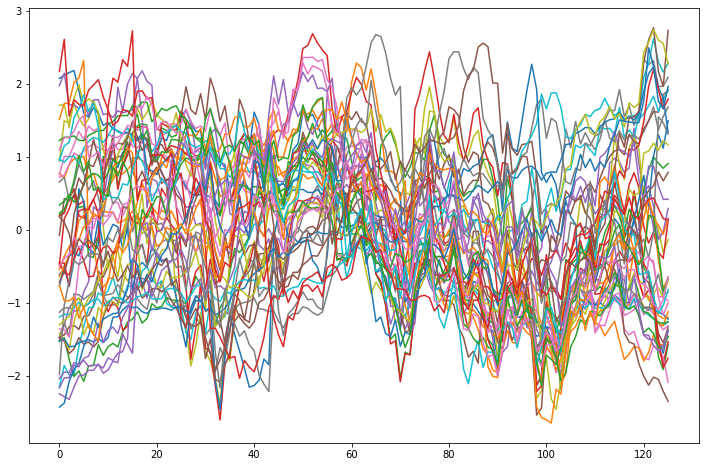

In [110]:
plt.figure(figsize=(12,8))
plt.plot(tickers_scaled.T);

# Basik KMeans

  0%|          | 0/9 [00:00<?, ?it/s]

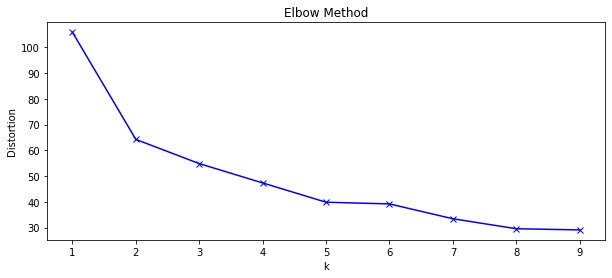

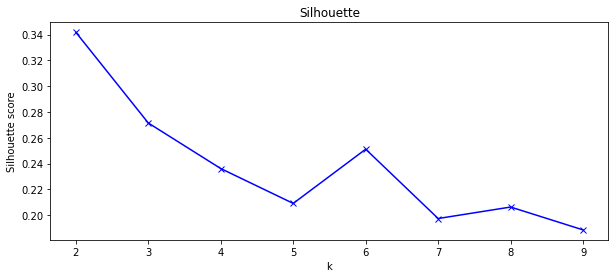

In [115]:
distortions = []
silhouette = []
K = range(1, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="euclidean", n_jobs=6, max_iter=10)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    if k > 1:
        silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_))

plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(K[1:], silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette')
plt.show()

In [116]:
n_clusters = 6
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=3, max_iter=10)
ts_kmeans.fit(tickers_scaled)

TimeSeriesKMeans(max_iter=10, n_clusters=6, n_jobs=3)

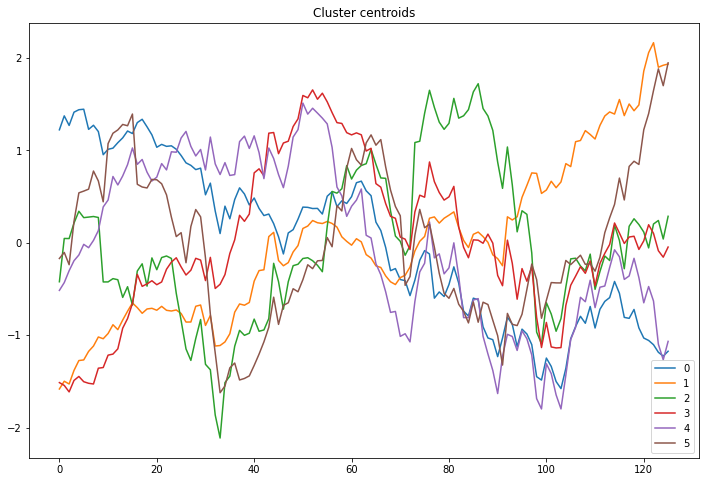

In [117]:
plt.figure(figsize=(12,8))
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [140]:
components_distance(1, 2, components_distance='eucliden')

Exception: Unknown distance: chosen distance between componentsshould be euclidean or cityblock

In [143]:
type(np.array([]))

numpy.ndarray

In [144]:
np.ones((50,50)) * np.inf

array([[inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]])

In [160]:
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [207]:
dtw(query, template, keep_internals=True, window_type='slantedband',
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2)

TypeError: slantedBandWindow() missing 1 required positional argument: 'window_size'

In [170]:
dtw(query, template).distance

25.212348449841407

In [209]:
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

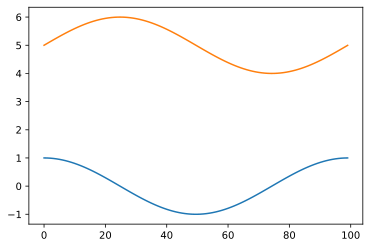

In [269]:
plt.plot(template)
plt.plot(query)

In [303]:
type(template)

numpy.ndarray

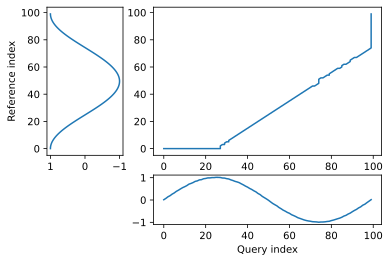

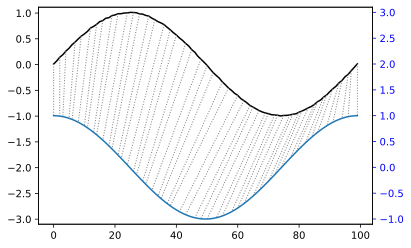

<AxesSubplot:>

In [284]:
idx = np.linspace(0,6.28,num=100)
query = np.sin(idx) + np.random.uniform(size=100)/50.0

## A cosine is for template; sin and cos are offset by 25 samples
template = np.cos(idx)
# query = np.cos(idx)

## Find the best match with the canonical recursion formula
from dtw import *
alignment = dtw(query, template, keep_internals=True)

## Display the warping curve, i.e. the alignment curve
alignment.plot(type="threeway")

## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
dtw(query, template, keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2)



In [314]:
mc = df.iloc[9].values[5:].tolist()
visa = df.iloc[14].values[5:].tolist()

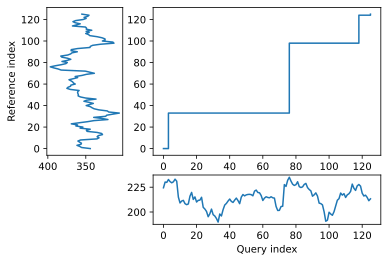

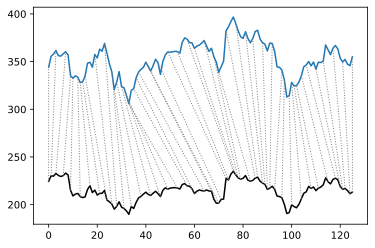

<AxesSubplot:>

In [337]:
alignment = dtw(mc, visa, keep_internals=True)

## Display the warping curve, i.e. the alignment curve
alignment.plot(type="threeway")

## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
dtw(mc, visa, keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(5, "c")
    )\
    .plot(type="twoway", offset=0)

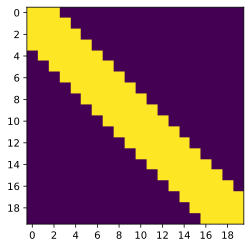

In [346]:
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
n = 20
m = np.zeros((n, n))
k = 3
for i in range(n):
    for j in range(i - k, i + k):
        if 0 <= j < n:
            m[i, j] = 1

plt.imshow(m);

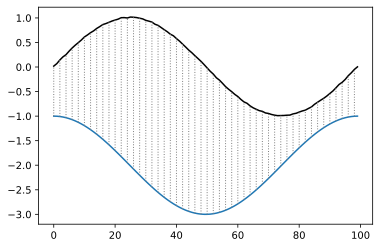

In [283]:
t = template - 2
step = 2
indices = np.arange(template.size, step=step)
plt.plot(t)
plt.plot(query, color='k')
for indx in indices:
    plt.vlines(indx, ymin=t[indx], ymax=query[indx], 
               linestyles='dotted', color='gray', linewidth=1.0)

In [249]:
idx = np.linspace(0, 6.28,num=100)

template = np.cos(idx)
query = np.sin(idx) + 5

In [265]:
step = 5
indices = np.arange(template.size, step=step)

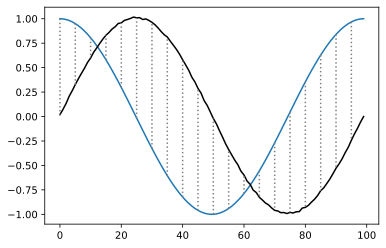

In [266]:
plt.plot(template)
plt.plot(query, color='k')
for indx in indices:
    plt.vlines(indx, ymin=template[indx], ymax=query[indx], linestyles='dotted', color='gray')

In [ ]:
linestyles : {'solid', 'dashed', 'dashdot', 'dotted'

AttributeError: 'LineCollection' object has no property 's'

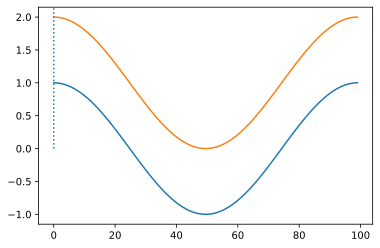

In [236]:
plt.plot(template)
plt.plot(query);
plt.vlines(0, ymin=0, ymax=10, linestyles='dotted', s=3, color='gray')

In [153]:
def components_distance(component_1, component_2, distance='euclidean'):
    if distance == 'euclidean':
        return (component_1 - component_2) ** 2
    elif distance == 'cityblock':
        return abs(component_1 - component_2)
    else:
        raise Exception('Unknown distance: chosen distance between components' \
                        'should be euclidean or cityblock.')

        
@numba.jit(numba.int8(numba.int8[:], numba.int8[:]), nopython=True)
def dtw_distance(vector_1: np.ndarray, vector_2: np.ndarray, distance='euclidean'):
    n, m = vector_1.size, vector_2.size
    dtw = np.ones((n + 1, m + 1)) * np.inf
    dtw[0, 0] = 0
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = components_distance(
                vector_1[i - 1],
                vector_2[j - 1],
                distance=distance
            )
            dtw[i, j] = cost + min(dtw[i - 1, j], dtw[i, j - 1], dtw[i - 1, j - 1])
    return dtw[n, m]

In [195]:
dtw(a, b, dist_method='euclidean', distance_only=True).plot(type="twoway",offset=-2)

ValueError: Original timeseries are required

In [186]:
dtw(a, b, keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=)

ValueError: cannot convert float NaN to integer

In [180]:
a = np.array([1, 4, 5, 10, 9, 3, 2, 6, 8, 4])
b = np.array([1, 7, 3, 4, 1, 10, 5, 4, 7, 4])
dtw_distance(a, b, distance='euclidean')

37.0

In [181]:
np.sum(np.abs(a - b))

32

In [118]:
snp500['cluster'] = ts_kmeans.predict(tickers_scaled)
pd.DataFrame(snp500.groupby('cluster')['sector'].value_counts())

/home/mbulygin/anaconda3/envs/working-environment/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 47 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


sector
cluster sector                        
0       Communication Services       4
        Technology                   4
        Financial Services           3
        Healthcare                   1
        Industrials                  1
1       Healthcare                   4
        Consumer Defensive           2
        Energy                       2
2       Financial Services           3
        Communication Services       1
        Consumer Defensive           1
3       Technology                   3
        Consumer Defensive           2
        Consumer Cyclical            1
        Healthcare                   1
4       Consumer Cyclical            3
        Healthcare                   3
        Technology                   3
        Communication Services       2
5       Communication Services       1
        Consumer Defensive           1
        Healthcare                   1

In [119]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[5:-1])
        ax[index].set_title(f"{row.shortName}\n{row.sector}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

                          Cluster number: 0


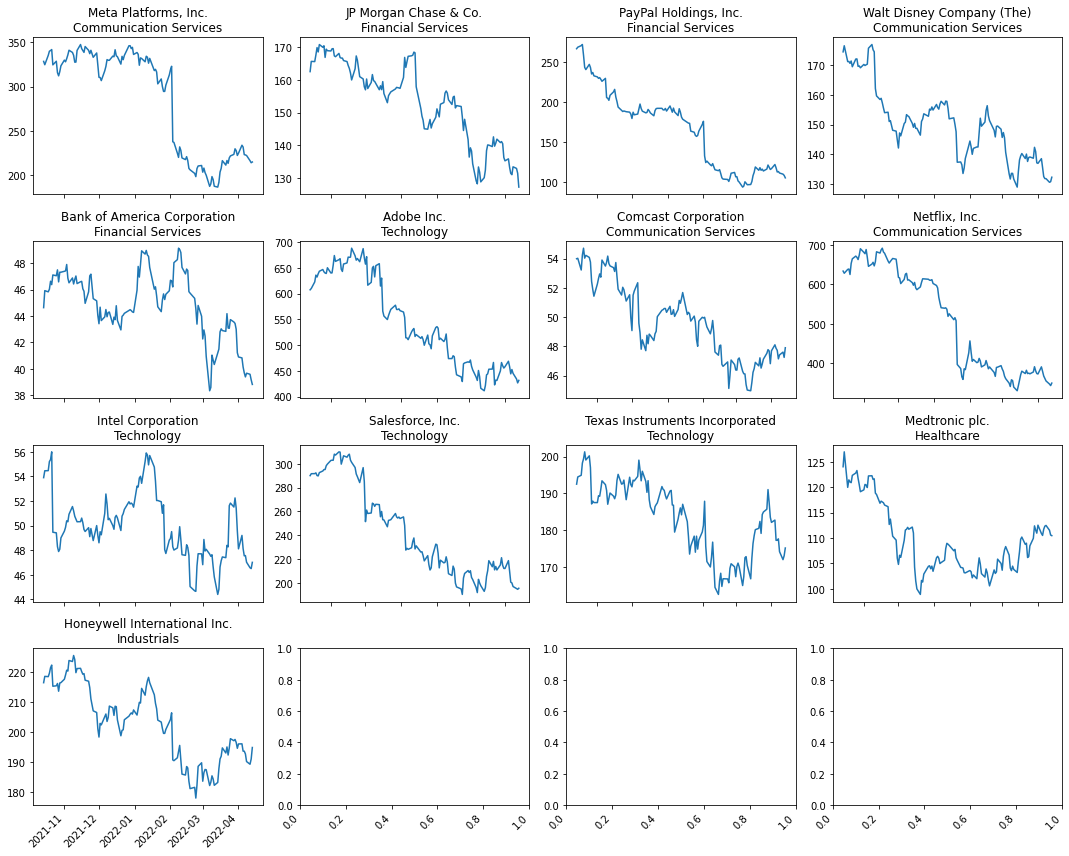

                          Cluster number: 1


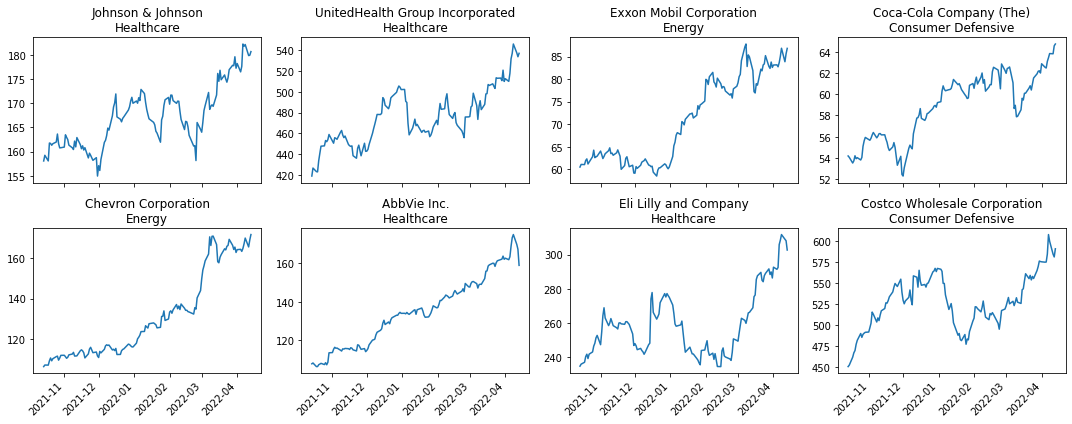

                          Cluster number: 2


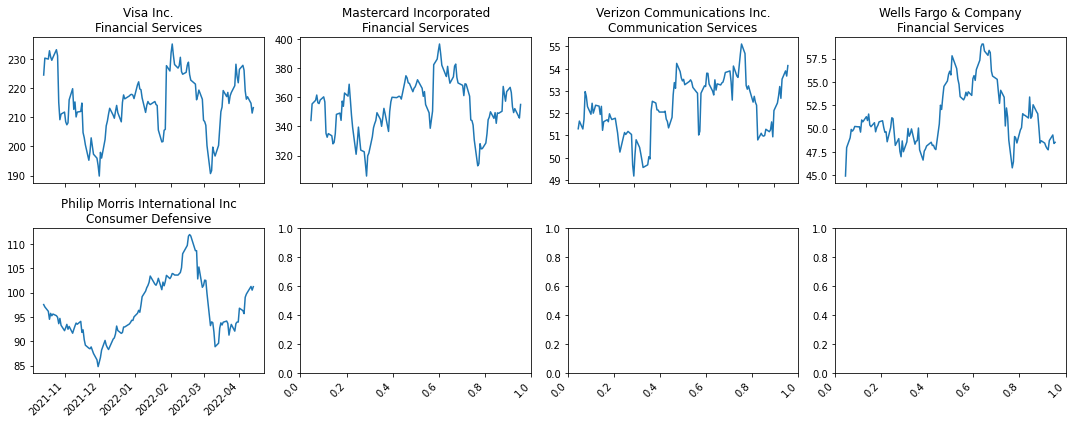

                          Cluster number: 3


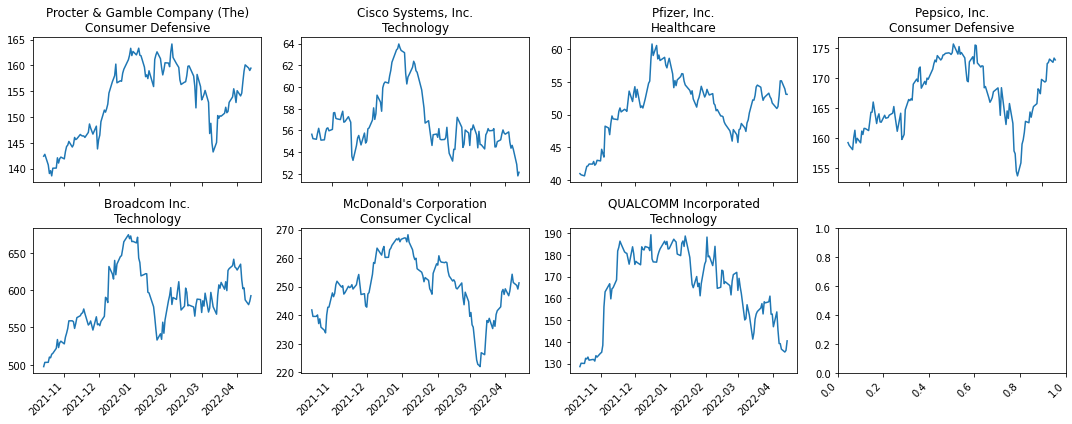

                          Cluster number: 4


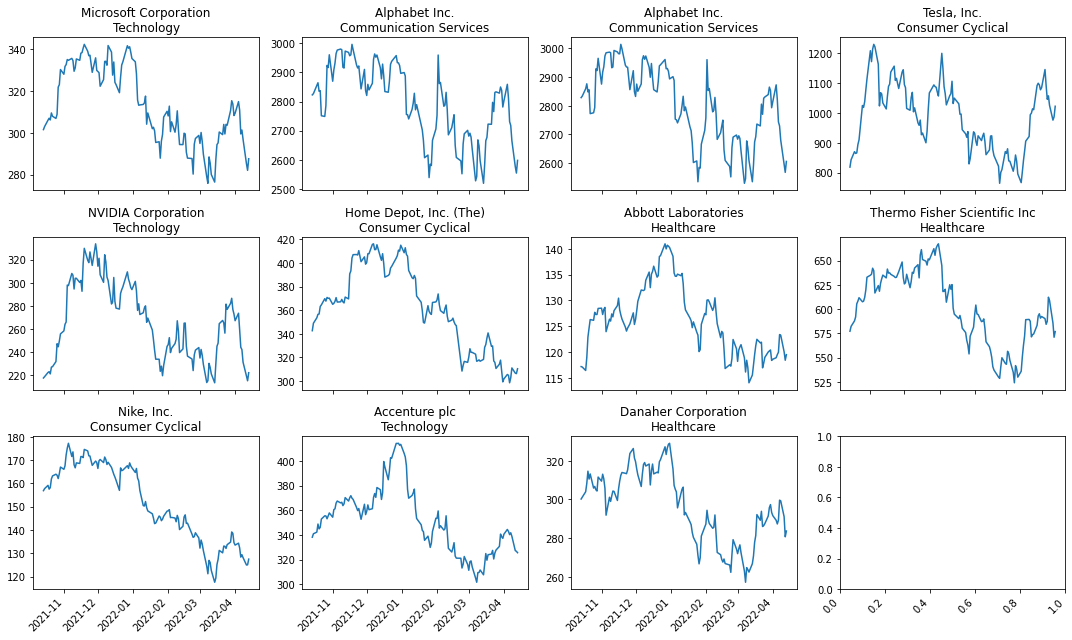

                          Cluster number: 5


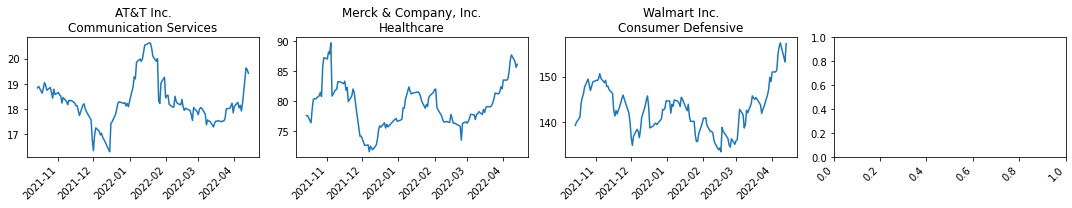

In [120]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(snp500[snp500.cluster==cluster])

### DTW

$$DTW(x, y) = min_{\pi} \sqrt{\sum_{(i,j)\in \pi} d(x_i, y_j)^2},$$

где $\pi = [\pi_0, ..., \pi_K]$ - это путь, удовлетворяющий набору условий:
 - это лист парных индексов $\pi_k = (i_k, j_k)$, где  $0 \leq i_k \lt n$ и $0 \leq j_k \lt m $;
 -  $\pi_0 = (0, 0)$ и $\pi_K = (n-1, m-1)$
для всех $k\gt0$,
 - $\pi_k=(i_k, j_k)$ и $\pi_{k-1}=(i_{k-1}, j_{k-1})$ удовлетворяют следующим неравенствам:
- $i_{k-1} \leq i_k \leq i_{k-1} + 1$
- $j_{j-1} \leq j_k \leq j_{k-1} + 1$


А если по-человечески:
- Путь - это индексы временных рядов
- Путь может ходить по диагонали, горизонтали и вертикали, 
главное, чтобы был неубывающим по индексам
- Стартуем всегда в начале временных рядов, заканчиваем всегда в конце


https://upload.wikimedia.org/wikipedia/commons/8/84/Animation_Dynamic_Time_Warping.gif

  0%|          | 0/9 [00:00<?, ?it/s]

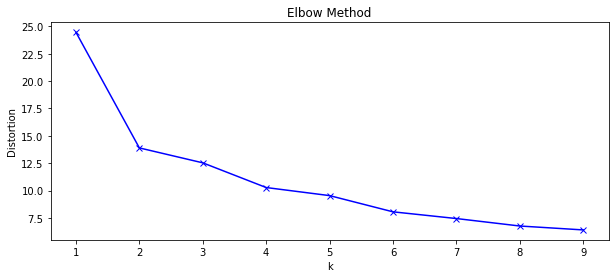

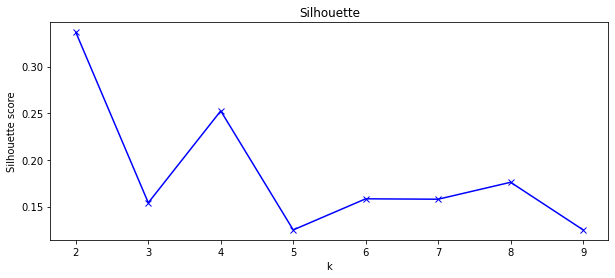

In [121]:
distortions = []
silhouette = []
K = range(1, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=6, max_iter=10)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    if k > 1:
        silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_))

plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(K[1:], silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette')
plt.show()

In [122]:
n_clusters = 6
ts_kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=6, max_iter=10)
ts_kmeans_dtw.fit(tickers_scaled)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=6, n_jobs=6)

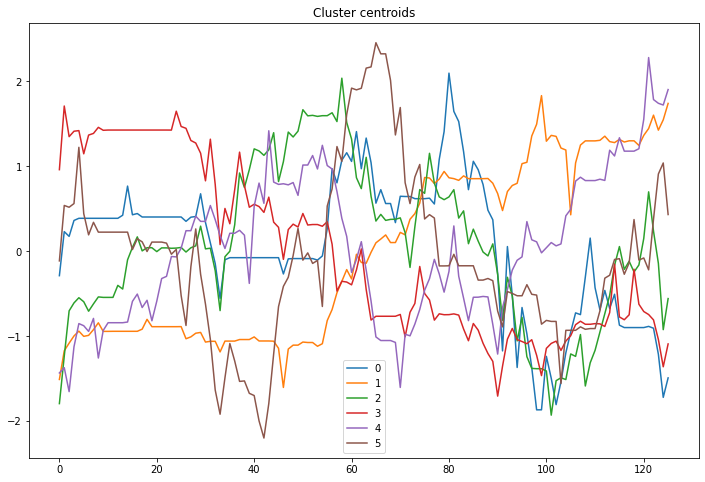

In [123]:
plt.figure(figsize=(12,8))
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans_dtw.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")

plt.legend()
plt.show()

In [124]:
snp500['cluster'] = ts_kmeans_dtw.predict(tickers_scaled)
pd.DataFrame(snp500.groupby('cluster')['sector'].value_counts())

/home/mbulygin/anaconda3/envs/working-environment/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 47 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


sector
cluster sector                        
0       Communication Services       2
        Technology                   2
        Consumer Cyclical            1
        Financial Services           1
        Healthcare                   1
1       Energy                       2
        Consumer Defensive           1
        Healthcare                   1
2       Technology                   4
        Healthcare                   3
        Consumer Cyclical            2
        Financial Services           1
3       Communication Services       4
        Technology                   4
        Financial Services           2
        Consumer Cyclical            1
        Healthcare                   1
        Industrials                  1
4       Consumer Defensive           4
        Healthcare                   4
5       Communication Services       2
        Financial Services           2
        Consumer Defensive           1

                          Cluster number: 0


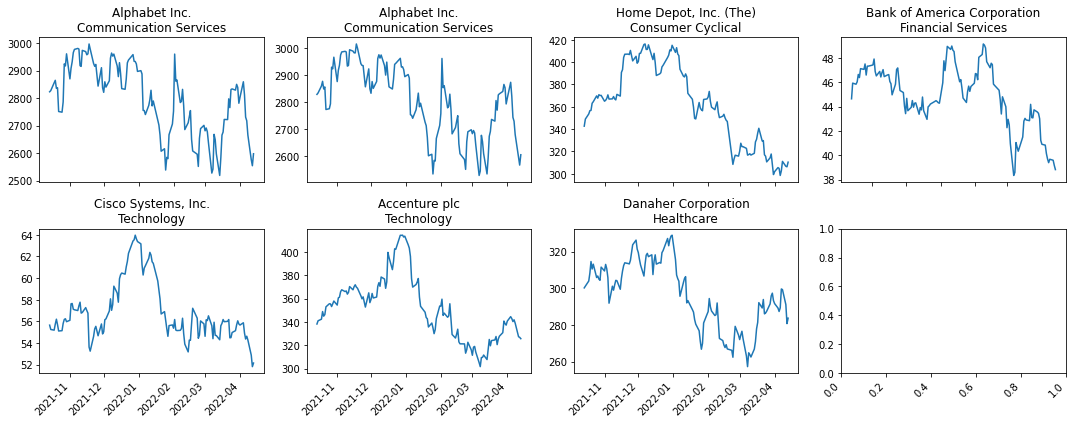

                          Cluster number: 1


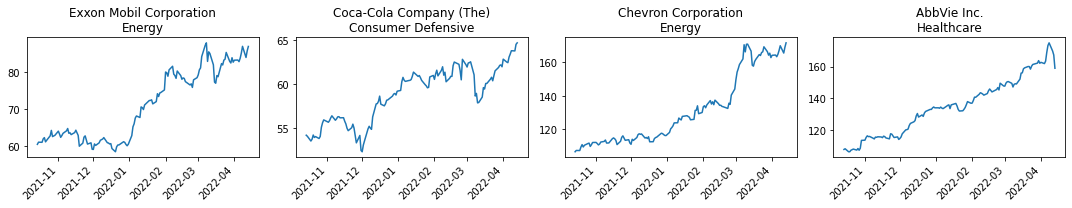

                          Cluster number: 2


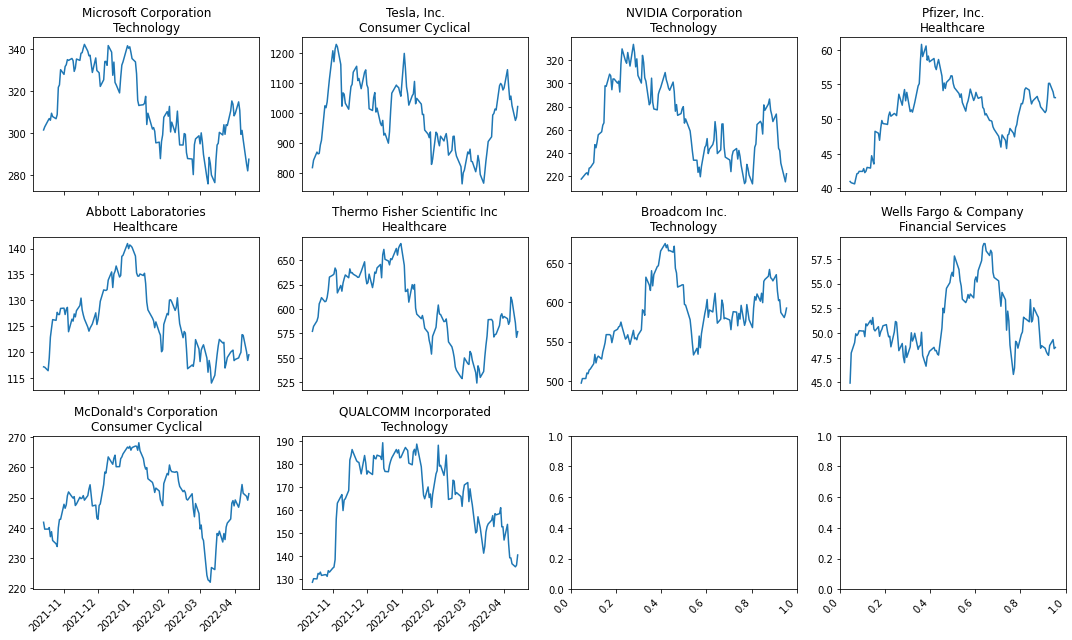

                          Cluster number: 3


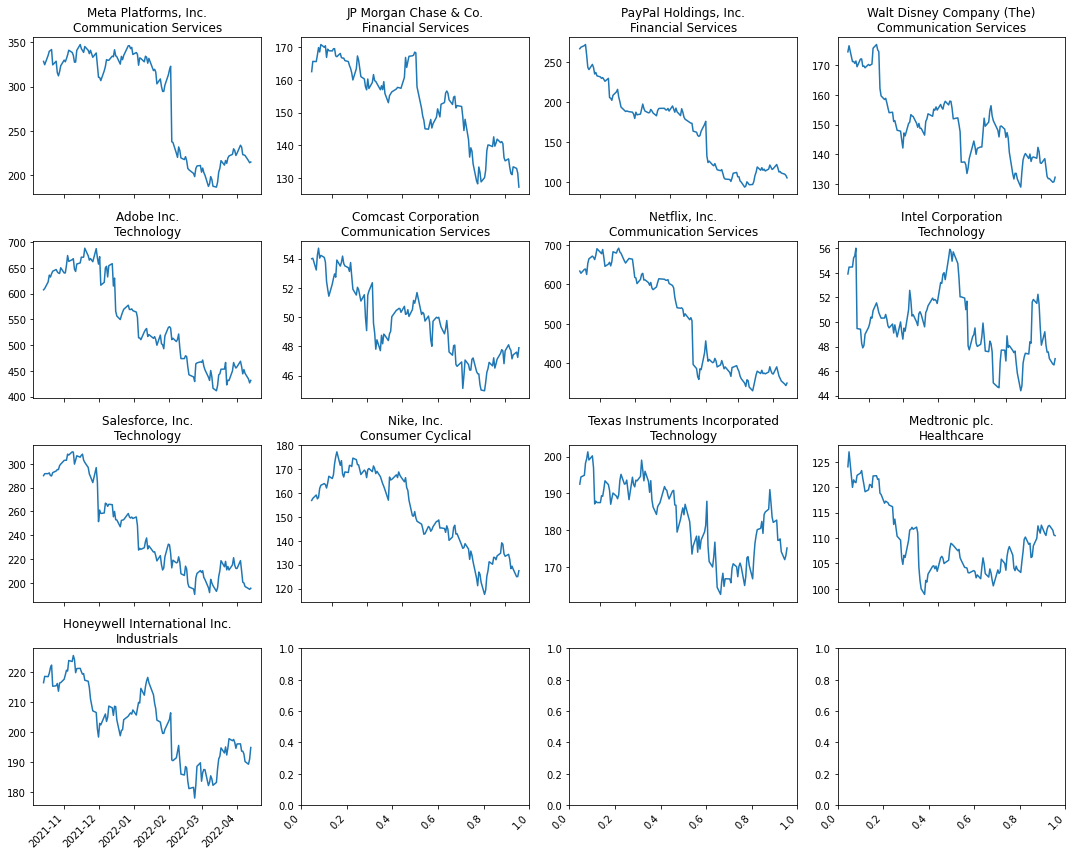

                          Cluster number: 4


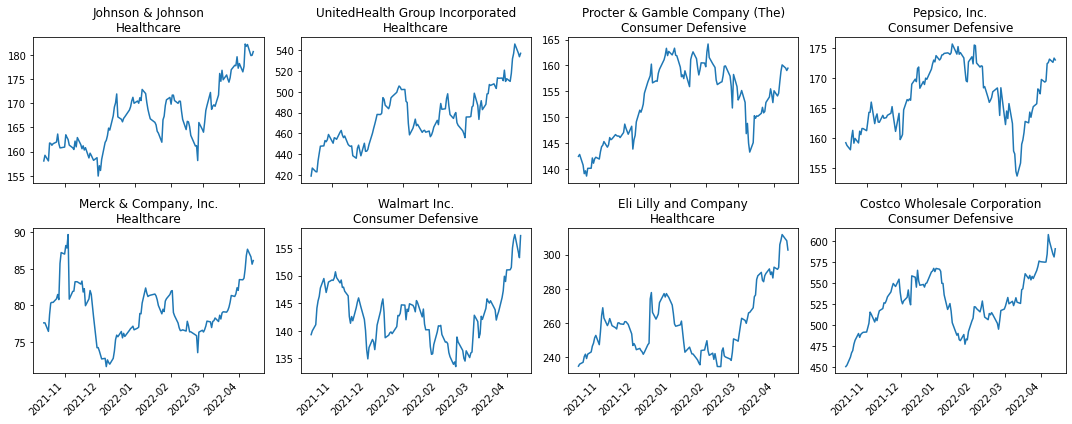

                          Cluster number: 5


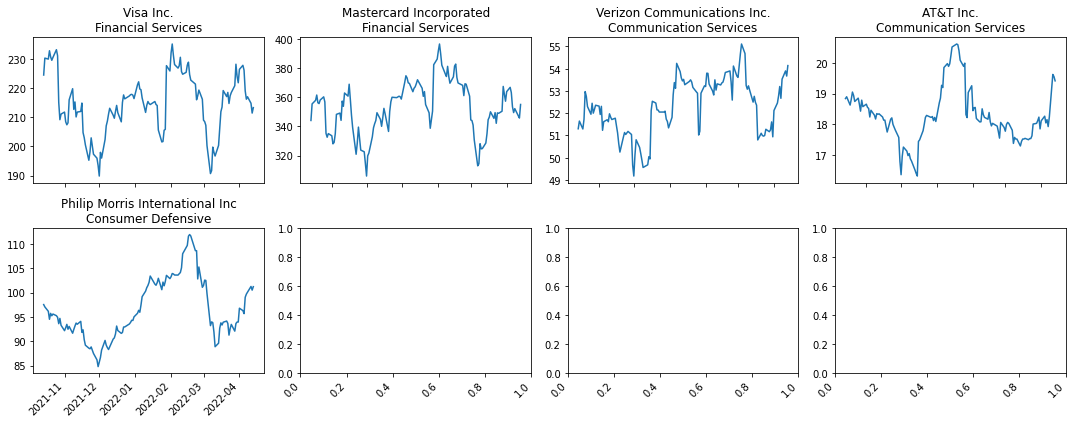

In [125]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(snp500[snp500.cluster==cluster])

## VRAE

Timeseries clustering is an unsupervised learning task aimed to partition unlabeled timeseries objects into homogenous groups/clusters. Timeseries in the same cluster are more similar to each other than timeseries in other clusters

This algorithm is able to:

- Identify joint dynamics across the sequences
- Eliminate lags (time-shifts) across sequences (usually called lag-invariance)
- Generate features which are interpretable.

In general, timeseries clustering algorithms are of two types:

 - Feature based - transform raw data using feature extraction, run clustering on top of generated features
 - Raw-data based - directly applied over timeseries vectors without any space-transformations


VRAE is a feature-based timeseries clustering algorithm, since raw-data based approach suffers from curse of dimensionality and is sensitive to noisy input data. The middle bottleneck layer will serve as the feature representation for the entire input timeseries.

In [126]:
tickers_scaled.shape

(47, 126)

In [127]:
! git clone https://github.com/tejaslodaya/timeseries-clustering-vae.git

Cloning into 'timeseries-clustering-vae'...
remote: Enumerating objects: 106, done.
remote: Total 106 (delta 0), reused 0 (delta 0), pack-reused 106
Receiving objects: 100% (106/106), 3.94 MiB | 9.77 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [130]:
from timeseries_clustering_vae.vrae.vrae import VRAE
from timeseries_clustering_vae.vrae.utils import *
import numpy as np
import torch

import plotly
from torch.utils.data import DataLoader, TensorDataset
plotly.offline.init_notebook_mode()

ModuleNotFoundError: No module named 'timeseries_clustering_vae'

In [ ]:
dload = '/content/timeseries_clustering_vae/' #download directory

In [ ]:
hidden_size = 50
hidden_layer_depth = 1
latent_length = 20
batch_size = 5
learning_rate = 0.0005
n_epochs = 40
dropout_rate = 0.1
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

In [ ]:
def prepare_data(tiker_scaled_df, ratio_train=0.9):
    """Input:
    direc: location of the UCR archive
    ratio_train: ratio to split training and testset
    dataset: name of the dataset in the UCR archive"""

    data = tiker_scaled_df
    # data = np.concatenate((data_train, data_test_val), axis=0)
    data = np.expand_dims(data, -1)
    

    N, D, _ = data.shape

    ind_cut = int(ratio_train * N)
    ind = np.random.permutation(N)
    return data[ind[:ind_cut], :, :], data[ind[ind_cut:], :, :], np.zeros(shape=(45,1)), np.zeros(shape=(45,1))

In [ ]:
X_train, X_val, y_train, y_val = prepare_data(tickers_scaled, ratio_train=0.9)

num_classes = len(np.unique(y_train))
base = np.min(y_train)  # Check if data is 0-based
if base != 0:
    y_train -= base
y_val -= base

In [ ]:
print(X_train.shape, X_val.shape)

(45, 124, 1) (5, 124, 1)


In [ ]:
train_dataset = TensorDataset(torch.from_numpy(X_train))
test_dataset = TensorDataset(torch.from_numpy(X_val))

In [ ]:
sequence_length = X_train.shape[1]
number_of_features = X_train.shape[2]

In [ ]:
vrae = VRAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning:

size_average and reduce args will be deprecated, please use reduction='sum' instead.



In [ ]:
vrae.fit(train_dataset)

In [ ]:
z_run = vrae.transform(test_dataset)

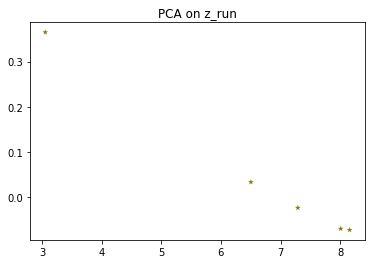

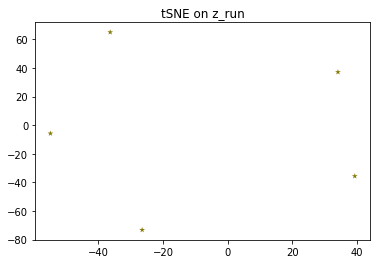

In [ ]:
plot_clustering(z_run, y_val, engine='matplotlib', download = False)

### Variational Recurrent Auto-encoders (VRAE) Vanila

In [ ]:
X_train, X_val, y_train, y_val = open_data(dload + 'data', ratio_train=0.9)

num_classes = len(np.unique(y_train))
base = np.min(y_train)  # Check if data is 0-based
if base != 0:
    y_train -= base
y_val -= base

In [ ]:
train_dataset = TensorDataset(torch.from_numpy(X_train))
test_dataset = TensorDataset(torch.from_numpy(X_val))

In [ ]:
sequence_length = X_train.shape[1]

In [ ]:
number_of_features = X_train.shape[2]

In [ ]:
hidden_size = 90
hidden_layer_depth = 1
latent_length = 20
batch_size = 32
learning_rate = 0.0005
n_epochs = 40
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

In [ ]:
vrae = VRAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning:

size_average and reduce args will be deprecated, please use reduction='sum' instead.



In [ ]:
vrae.fit(train_dataset)

In [ ]:
z_run = vrae.transform(test_dataset)

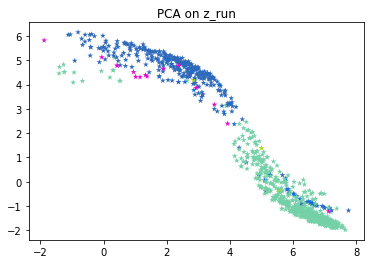

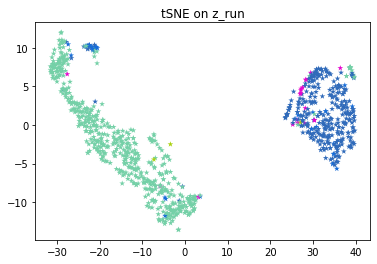

In [ ]:
plot_clustering(z_run, y_val, engine='matplotlib', download = False)

## DeepTemporalClustering

In [ ]:
! git clone https://github.com/FlorentF9/DeepTemporalClustering.git

Cloning into 'DeepTemporalClustering'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 59 (delta 0), reused 0 (delta 0), pack-reused 56
Unpacking objects: 100% (59/59), done.


In [ ]:
! python3 DeepTemporalClustering/DeepTemporalClustering.py --help

2021-07-29 08:53:23.817254: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
usage: DeepTemporalClustering.py [-h] [--dataset DATASET]
                                 [--ae_weights AE_WEIGHTS]
                                 [--n_clusters N_CLUSTERS]
                                 [--n_filters N_FILTERS]
                                 [--kernel_size KERNEL_SIZE]
                                 [--strides STRIDES] [--pool_size POOL_SIZE]
                                 [--n_units N_UNITS N_UNITS] [--gamma GAMMA]
                                 [--alpha ALPHA]
                                 [--dist_metric {eucl,cid,cor,acf}]
                                 [--cluster_init {kmeans,hierarchica

## Time2Vec for Time Series features encoding

https://towardsdatascience.com/time2vec-for-time-series-features-encoding-a03a4f3f937e

https://arxiv.org/abs/1907.05321

https://github.com/email81227/Time2Vec-TensorFlow2

## Encoder-Decoder Model for Multistep Time Series Forecasting

https://towardsdatascience.com/encoder-decoder-model-for-multistep-time-series-forecasting-using-pytorch-5d54c6af6e60

https://github.com/gautham20/pytorch-ts